##### **Instituto Tecnológico de Costa Rica**
##### **Programa Ciencia de los Datos**
##### **Curso: Big Data**
##### **Solución Tarea 3**

---

# Preprocesamiento de datos

## Bibliotecas

In [ ]:
import findspark
from pyspark.sql.types import (StringType, IntegerType, FloatType,DecimalType, StructField, StructType, DoubleType)
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, round, when, lit, count, isnan, concat
import pyspark.sql.functions as F
from pyspark.sql import SQLContext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import seaborn as sns
from pyspark.ml.feature import StandardScaler
from pyspark.ml.functions import vector_to_array
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.classification import RandomForestClassifier

---

## Funciones

In [ ]:
def na_percent(df, show = False):
    """
    Calcula el porcentaje de valores perdidos (NA) presentes en cada columna del conjunto 
    de datos e imprime una tabla con la información. 
    
    df: dataframe.
    show: especificar si se desea imprimir o no la tabla.     
    """
        
    NA_df = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
    for colu in NA_df.columns:
        NA_df = NA_df.withColumn(colu, round(col(colu) * 100 / df.count(), 2))
        
    if show == True:
        NA_df.show(vertical = True)
        
    return NA_df

In [ ]:
def input_median(df, df_col):
    """
    Calcula e imputa la mediana de una columna para los valores nulos. 
    Retorna el dataframe completo y con las columnas modificadas. 
    
    df: dataframe.
    df_col: columna del dataframe a la que se le imputa la mediana. 
    """
    median = df.approxQuantile(df_col, [0.50], 0)[0]
    df = df.withColumn(df_col, when(col(df_col).isNull(), median).otherwise(col(df_col)))
    
    return df

In [ ]:
def rdd_col(df, df_cols):
    """
    Convierte una o varias columnas a rdd y retorna una lista con las columnas transformadas. 
    
    df: dataframe.
    df_col: lista con columnas del dataframe que se desea convertir a rdd. 
    """  
    
    
    rdd_columns = []  
    
    for column in df_cols:
        df_col_list = df.select(column).rdd.flatMap(lambda x: x).collect()
        df_col_rdd = sparkContext.parallelize(df_col_list)
        rdd_columns.append(df_col_list) #(df_col_rdd)
    
    return rdd_columns

In [ ]:
def rangos_filas_cols(datos, num1, num2):
    """
    Prepara los datos para ser graficados en una matriz de histogramas. 
    Recibe una lista de listas (tipo rdd) y las divide en una cantidad n de listas, cada una con n elementos. 
    
    datos: lista de listas tipo rdd (previamente convertidas).
    num1: Cantidad de listas rdd que se graficarán.
    num2: Número que divida a num1. El cual determinará la cantidad de filas o columnas que tendrá la matriz de histogramas. 
    """
        
    div = int(num1 / num2)
    rows2 = range(0, num2)
    cols2 = range(0, div)
       
    if num1 % num2 != 0:
        return "El número 1 debe ser divisible por el número 2"
    
    else: 
        rango = np.arange(0, num1 + 1, num2)
        a = 0
        lista_rangos = []
        for i in rango[:-1]:
            a = a + rango[1]
            subrango = range(i, a)
            lista_rangos.append(subrango)
            
        datos_divididos_lista = []

        for r in rows2:
            for c in cols2: 
                
                colu = datos[lista_rangos[c][r]:lista_rangos[c][-1] + 1]
                
                if len(colu) == len(rows2):                   
                    datos_divididos_lista.append(colu)
                    
    return datos_divididos_lista

In [ ]:
def hist_matrix(datos, titulos, filas, columnas, ancho, alto, color, num_bins, tamaño_titulo):
    """
    
    Realiza un plot con n cantidad de histogramas según la forma de las listas de listas que se le pasen y el número
    de filas y columnas que se indique. 
     
    
    datos: lista_filas
    titulos: lista titulos
    filas: número filas
    columnas: número columnas
    ancho: ancho de figura
    alto: alto de figura
    color: color de histogramas
    num_bins: cantidad de cubetas
    tamaño_titulo: Tamaño de letra de los títulos    
    """
    fig, axs = plt.subplots(filas, columnas, tight_layout= False, figsize=(ancho, alto)) 

    rows = range(0, filas)
    cols = range(0,columnas)

    for r in rows:
        for c in cols:       
            axs[r, c].hist(datos[c][r], num_bins, facecolor= color, alpha=0.5)
            axs[r, c].set_title(titulos[c][r], fontsize = tamaño_titulo)

In [ ]:
def groupby_count(df, df_cols, filter_col, filter_val):
    """
    Agrupa un dataframe según una o varias columnas a especificar y filtra las filas que contengan y las que no contengan
    el valor especificado en la columna usada para filtrar.
    
    Retorna:
    grouped_df: el dataframe agrupado
    yes_df: un dataframe con las filas que contienen el valor de filtro
    no_df: un dataframe con las filas que contienen el valor de filtro
    max_y: el máximo valor de los conteos de grouped_df. 
    
    df: dataframe.
    df_cols: Lista de columnas que se van a agrupar y seleccionar. 
    filter_col: Columna que contiene los valores por los que se filtrará grouped_df.
    filter_val: Valor para filtrar grouped_df.
    """
    
    grouped_df = df.groupBy(df_cols).count().sort(df_cols)
    yes_df = rdd_col(grouped_df.filter(col(filter_col) == filter_val), grouped_df.columns)
    no_df = rdd_col(grouped_df.filter(col(filter_col) != filter_val), grouped_df.columns)
    max_y = grouped_df.agg({"count": "max"}).collect()[0][0]
    
    return grouped_df, yes_df, no_df, max_y

In [ ]:
def bar_plot(data1, data2, x_labels, legend_labels, colors, ancho, alto, title, xlims, ylims, width = 0.35): 
    """
    Crea un gráfico de barras para datos agrupados por una variable. 
    
    data1: datos que corresponderán al primer label de la leyenda. 
    data2: datos que corresponderán al segundo label de la leyenda.
    x_labels: lista con labels para el eje x. 
    legend_labels: lista con labels para la leyenda. 
    colors: lista con colores para las barras según la leyenda. 
    ancho: ancho del gráfico.
    alto: alto del gráfico. 
    title: título del gráfico.  
    xlims: límites del eje x. 
    ylims: límites del eje y.
    width: ancho de las barras.     
    """
    
    
    labels = x_labels
    yes_counts = data1
    no_counts = data2

    x = np.arange(len(labels))  

    fig, ax = plt.subplots(tight_layout = False, figsize=(ancho, alto))
    rects1 = ax.bar(x - width/2, yes_counts, width, label=legend_labels[0], color = colors[0])
    rects2 = ax.bar(x + width/2, no_counts, width, label=legend_labels[1], color = colors[1])

    ax.set_ylabel('Count')
    ax.set_ylim(ylims[0], ylims[1])
    ax.set_xlim(width - xlims[0], width + xlims[1])

    ax.set_title(title)
    ax.set_xticks(x, labels)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    plt.show()

---

## Cargar datos

In [ ]:
findspark.init('/usr/lib/python3.7/site-packages/pyspark')

# Creación de la sesión de spark

spark = SparkSession \
    .builder \
    .appName("Tarea_3") \
    .config("spark.driver.extraClassPath", "postgresql-42.2.14.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.2.14.jar") \
    .getOrCreate()

sparkContext=spark.sparkContext
spark.sparkContext.setLogLevel("ERROR")

# Cargar csv

df = spark \
    .read \
    .format("csv") \
    .option("path", "Metabolic Syndrome.csv") \
    .option("header", True) \
    .option("sep", ",") \
    .schema(StructType([
                StructField("ID", IntegerType()),
                StructField("Age", FloatType()),
                StructField("Sex", StringType()),
                StructField("Marital", StringType()),
    
                StructField("Income", FloatType()),
                StructField("Race", StringType()),
                StructField("WaistCirc", FloatType()),
                StructField("BMI", FloatType()),
    
                StructField("Albuminuria", IntegerType()),
                StructField("UrAlbCr", FloatType()),
                StructField("UricAcid", FloatType()),
                StructField("BloodGlucose", IntegerType()),
    
                StructField("HDL", IntegerType()),
                StructField("Triglyc", IntegerType()),
                StructField("MetSyndr", StringType())])) \
    .load()

print("Schema del conjunto de datos: \n")
df.printSchema()
print("-------------------------------------------")
print("\n Primeras filas del conjunto de datos: \n")
df.show(10)

Schema del conjunto de datos: 

root
 |-- ID: integer (nullable = true)
 |-- Age: float (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Marital: string (nullable = true)
 |-- Income: float (nullable = true)
 |-- Race: string (nullable = true)
 |-- WaistCirc: float (nullable = true)
 |-- BMI: float (nullable = true)
 |-- Albuminuria: integer (nullable = true)
 |-- UrAlbCr: float (nullable = true)
 |-- UricAcid: float (nullable = true)
 |-- BloodGlucose: integer (nullable = true)
 |-- HDL: integer (nullable = true)
 |-- Triglyc: integer (nullable = true)
 |-- MetSyndr: string (nullable = true)

-------------------------------------------

 Primeras filas del conjunto de datos: 

+-----+----+------+--------+------+-----+---------+----+-----------+-------+--------+------------+---+-------+---------+
|   ID| Age|   Sex| Marital|Income| Race|WaistCirc| BMI|Albuminuria|UrAlbCr|UricAcid|BloodGlucose|HDL|Triglyc| MetSyndr|
+-----+----+------+--------+------+-----+---------+----+------

---

### Descripción de las columnas

- **ID:** Identificador único para cada persona (no se utilizaría como feature). 

#### Features para los modelos de machine learning

- **Age:** Edad en años cumplidos.


- **Sex:** Sexo.


- **Marital:** Estado civil.


- **Income:** Ingreso económico.


- **Race:** Raza.


- **WaistCirc:** Circunferencia de la cintura en centímetros. 


- **BMI:** Índice de masa corporal.


- **Albuminuria:** Pérdida de albumina en la orina. 


- **UrAlbCr:** Cociente de albumina y creatinina en la orina. 


- **UricAcid:** Cantidad de ácido úrico en la orina. 


- **BloodGlucose:** Nivel de azúcar en la sangre, también llamada "glucosa". 


- **HDL:** Lipoproteína de alta densidad (high-density lipoprotein), conocida como colesterol "bueno". 


- **Triglyc:** Los triglicéridos son un tipo de grasa. Esta grasa se compone de calorías ingeridas pero que el cuerpo no necesita de inmediato. 

### Descripción del target

- **MetSyndr:** Síndrome Metabólico. 

Es el término médico para la combinación de diabetes, hipertensión y obesidad. De acuerdo con NHS UK (2019), el síndrome metabólico es un factor de riesgo para la enfermedad coronaria, los accidentes cerebro vasculares y otras condiciones que afectan los vasos sanguíneos. El síndrome metabólico se diagnostica si la persona posee 3 o más de los siguientes criterios: 


     - Un alto nivel de obesidad o una alta concentración de grasa abdominal. 
     - Alto nivel de triglicéridos y bajos niveles de HDL en la sangre. 
     - Presión alta, que consistentemente se mantiene en 140/90mmHg o más. 
     - Incapacidad de controlar los niveles de azúcar en la sangre (resistencia a la insulina).     


### Objetivo predictivo

- Se busca predecir si una persona tiene síndrome metabólico o no basándose en las demás variables del conjunto de datos (con excepción del ID). 

---

### Columnas seleccionadas como features + target

In [ ]:
# Seleccionar un subconjunto de las columnas de interés y el objetivo que es el síndrome metabólico
columnas = ['Age', 'Sex', 'Marital', 'Income', 'Race', 'WaistCirc', 'BMI','Albuminuria', 'UrAlbCr', 'UricAcid',
                'BloodGlucose', 'HDL', 'Triglyc', 'MetSyndr']

selected_columns_df = df.select(columnas)
selected_columns_df.show(10)

+----+------+--------+------+-----+---------+----+-----------+-------+--------+------------+---+-------+---------+
| Age|   Sex| Marital|Income| Race|WaistCirc| BMI|Albuminuria|UrAlbCr|UricAcid|BloodGlucose|HDL|Triglyc| MetSyndr|
+----+------+--------+------+-----+---------+----+-----------+-------+--------+------------+---+-------+---------+
|22.0|  Male|  Single|8200.0|White|     81.0|23.3|          0|   3.88|     4.9|          92| 41|     84|No MetSyn|
|44.0|Female| Married|4500.0|White|     80.1|23.2|          0|   8.55|     4.5|          82| 28|     56|No MetSyn|
|21.0|  Male|  Single| 800.0|Asian|     69.6|20.1|          0|   5.07|     5.4|         107| 43|     78|No MetSyn|
|43.0|Female|  Single|2000.0|Black|    120.4|33.3|          0|   5.22|     5.0|         104| 73|    141|No MetSyn|
|51.0|  Male| Married|  null|Asian|     81.1|20.1|          0|   8.13|     5.0|          95| 43|    126|No MetSyn|
|80.0|  Male| Widowed| 300.0|White|    112.5|28.5|          0|   9.79|     4.8| 

---

## Limpieza de datos

### Estadísticos descriptivos

In [ ]:
# Columnas numéricas para los estadísticos descriptivos
num_cols = ['Age', 'Income', 'WaistCirc', 'BMI', 'UrAlbCr', 'UricAcid', 'BloodGlucose', 'HDL', 'Triglyc']

# Resumen desriptivo de los datos

descriptivos = df.select(num_cols).summary()
descriptivos_pd = descriptivos.toPandas().set_index("summary")

print("Estadísticos descriptivos \n")
descriptivos_pd.transpose()

Estadísticos descriptivos 



summary      count                mean              stddev    min     25%  \
Age           2401   48.69179508538109   17.63285201410498   20.0    34.0   
Income        2284  4005.2539404553413     2954.0321859066  300.0  1600.0   
WaistCirc     2316   98.30725382770281  16.252634295815827   56.2    86.6   
BMI           2375  28.702189446700245   6.662242190178905   13.4    24.0   
UrAlbCr       2401    43.6261310107705   258.2728310597299    1.4    4.45   
UricAcid      2401   5.489046231005302  1.4393577741160652    1.8     4.5   
BloodGlucose  2401  108.24781341107872   34.82065689010629     39      92   
HDL           2401  53.369429404414824  15.185537474275257     14      43   
Triglyc       2401  128.12536443148687   95.32247738008883     26      75   

summary          50%     75%     max  
Age             48.0    63.0    80.0  
Income        2500.0  6200.0  9000.0  
WaistCirc       97.0   107.6   176.0  
BMI             27.7    32.1    68.7  
UrAlbCr         7.07   13.69  5928.0  
UricAcid         5.4     6.4    11.3  
BloodGlucose      99     110     382  
HDL               51      62     156  
Triglyc          103     150    1562

### Valores perdidos

In [ ]:
print("Porcentaje de valores perdidos \n")
nas = na_percent(df, True)


Porcentaje de valores perdidos 

-RECORD 0------------
 ID           | 0.0  
 Age          | 0.0  
 Sex          | 0.0  
 Marital      | 8.66 
 Income       | 4.87 
 Race         | 0.0  
 WaistCirc    | 3.54 
 BMI          | 1.08 
 Albuminuria  | 0.0  
 UrAlbCr      | 0.0  
 UricAcid     | 0.0  
 BloodGlucose | 0.0  
 HDL          | 0.0  
 Triglyc      | 0.0  
 MetSyndr     | 0.0  



### Tratamiento de valores perdidos

In [ ]:
# Para la columna "Marital" se creó una categoría llamada "Unknown" para mantener las filas con valores perdidos

df = df.withColumn("Marital", when(col("Marital").isNull(), "Unknown").otherwise(col("Marital")))

# Para las otras tres variables, como son numéricas se imputó la mediana con el fin de conservar las filas con nulos

df = input_median(df, "WaistCirc")
df = input_median(df, "Income")
df = input_median(df, "BMI")

In [ ]:
print("Porcentaje de valores perdidos después del tratamiento \n")
nas_after = na_percent(df, True)

Porcentaje de valores perdidos después del tratamiento 

-RECORD 0-----------
 ID           | 0.0 
 Age          | 0.0 
 Sex          | 0.0 
 Marital      | 0.0 
 Income       | 0.0 
 Race         | 0.0 
 WaistCirc    | 0.0 
 BMI          | 0.0 
 Albuminuria  | 0.0 
 UrAlbCr      | 0.0 
 UricAcid     | 0.0 
 BloodGlucose | 0.0 
 HDL          | 0.0 
 Triglyc      | 0.0 
 MetSyndr     | 0.0 



In [ ]:
# Se convirtieron los valores del target de string a 1/0 (1: Sí tiene síndrome metabólico, 0: No tiene síndrome metabólico)

df = df.withColumn("MetSyndr", when(col("MetSyndr") == "MetSyn", 1).otherwise(0))
df.select("MetSyndr").show(10)

+--------+
|MetSyndr|
+--------+
|       0|
|       0|
|       0|
|       0|
|       0|
|       0|
|       0|
|       0|
|       0|
|       0|
+--------+
only showing top 10 rows



---

## Gráficos

### Histogramas

In [ ]:
# Se convirtieron las columnas numéricas continuas a rdd para poder graficarlas

hist_cols = ['Age', 'Income', 'WaistCirc', 'BMI', 'UrAlbCr', 'UricAcid', 'BloodGlucose', 'HDL', 'Triglyc']
rdds = rdd_col(df, hist_cols) 

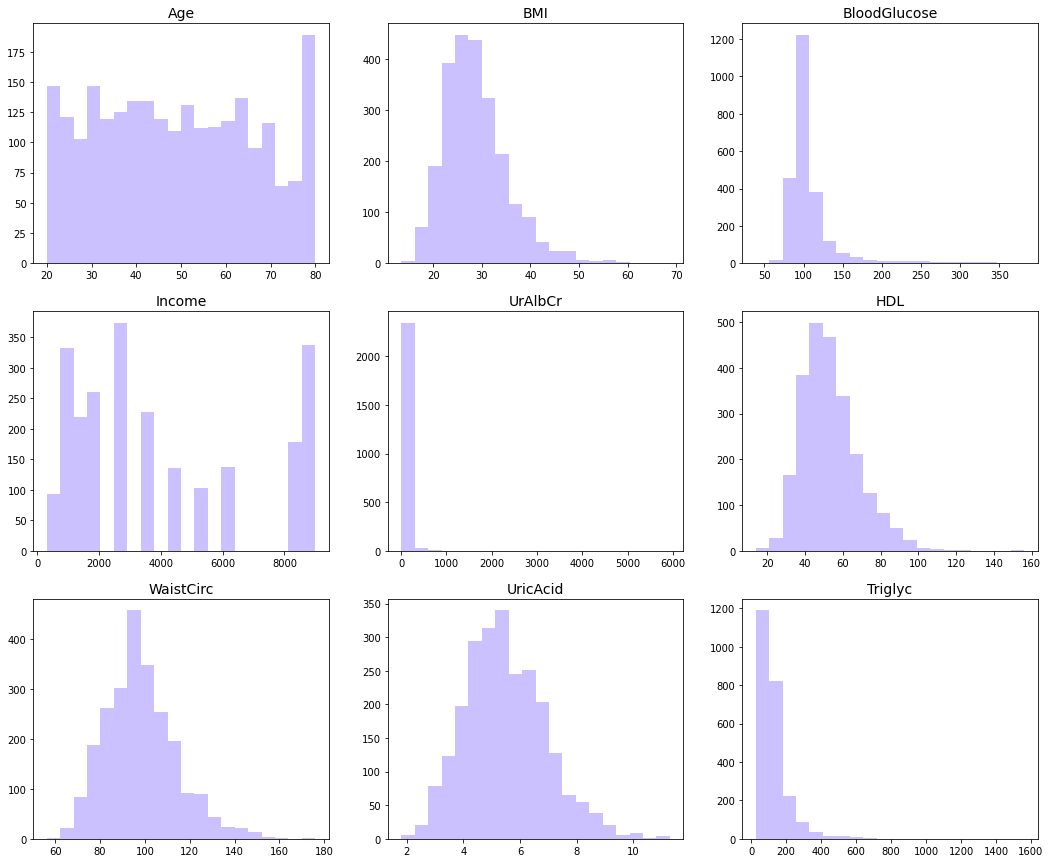

In [ ]:
# Se divide la cantidad de columnas en filas y columnas para pasarlas a la matriz de subplots

datos = rangos_filas_cols(rdds, 9, 3)

# Se genera una lista de títulos para cada gráfico 

titulos_lista = rangos_filas_cols(hist_cols, 9, 3)

# Creación de la matriz de histogramas
hist_matrix(datos, titulos_lista, filas = 3, columnas = 3, ancho = 18, alto = 15, color = "#9985ff", 
                                                                num_bins = 20, tamaño_titulo = 14)

### Gráficos de barras

In [ ]:
# Agrupación de las columnas categóricas según los diferentes valores y según si tienen síndrome metabólico o no 

grouped_sex, yes_met_sex, no_met_sex, max_y_sex = groupby_count(df, ["Sex", "MetSyndr"], "MetSyndr", 1)
grouped_race, yes_met_race, no_met_race, max_y_race = groupby_count(df, ["Race", "MetSyndr"], "MetSyndr", 1)
grouped_marital, yes_met_marital, no_met_marital, max_y_marital = groupby_count(df, ["Marital", "MetSyndr"], "MetSyndr", 1)
grouped_alb, yes_met_alb, no_met_alb, max_y_alb = groupby_count(df, ["Albuminuria", "MetSyndr"], "MetSyndr", 1)

# Agrupación de la columna target por cantidad de personas con o sin síndrome metabólico

meta_yesno = df.withColumn("MetSyndr", when(col("MetSyndr") == 1, "Yes").otherwise("No")).select("MetSyndr")
grouped_meta = meta_yesno.groupBy("MetSyndr").count()
metabolic_rdd = rdd_col(grouped_meta, ["MetSyndr", "count"])

#### Variables categóricas

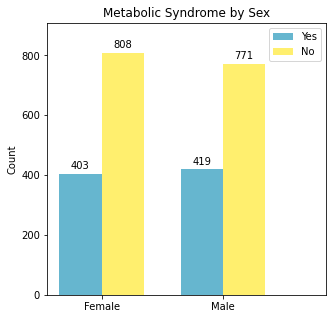

In [ ]:
# Metabolic Syndrome by Sex

plot_sex = bar_plot(yes_met_sex[2], no_met_sex[2], yes_met_sex[0], ["Yes", "No"], ["#66b6cf", "#ffef6e"], 5, 5,
                    'Metabolic Syndrome by Sex', [0.8, 1.5], [0, max_y_sex + 100])

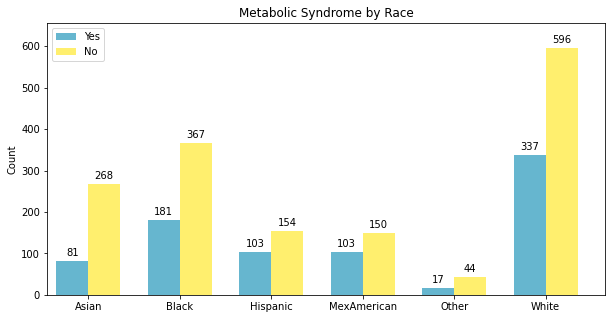

In [ ]:
# Metabolic Syndrome by Race

bar_plot(yes_met_race[2], no_met_race[2], yes_met_race[0], ["Yes", "No"], ["#66b6cf", "#ffef6e"], 10, 5, 
         'Metabolic Syndrome by Race', [0.8, 5.3], [0, max_y_race + 60])

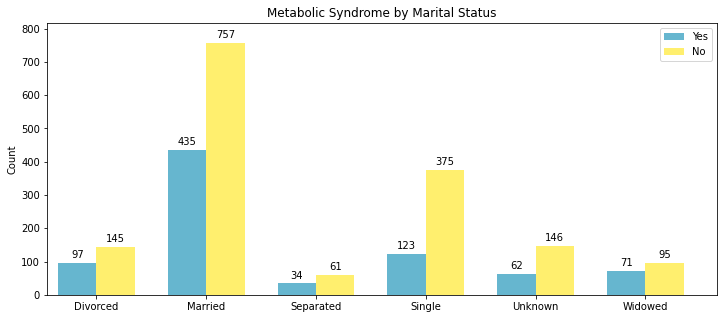

In [ ]:
# Metabolic Syndrome by Marital Status

bar_plot(yes_met_marital[2], no_met_marital[2], yes_met_marital[0], ["Yes", "No"], ["#66b6cf", "#ffef6e"], 12, 5,
         'Metabolic Syndrome by Marital Status', [0.8, 5.3], [0, max_y_marital + 60])

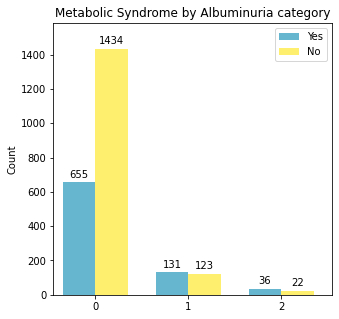

In [ ]:
# Metabolic Syndrome by Albuminuria category

bar_plot(yes_met_alb[2], no_met_alb[2], yes_met_alb[0], ["Yes", "No"], ["#66b6cf", "#ffef6e"], 5, 5, 'Metabolic Syndrome by Albuminuria category', [0.8, 2.2], [0, max_y_alb + 150], width = 0.35)

#### Target

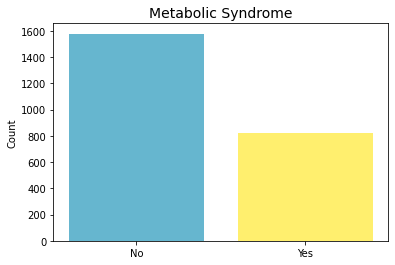

In [ ]:
# Metabolic Syndrome

plt.bar(metabolic_rdd[0], metabolic_rdd[1], color = ["#66b6cf", "#ffef6e"])
plt.title("Metabolic Syndrome", fontsize = 14)
plt.ylabel("Count")
plt.show()

### Matriz de correlación

In [ ]:
# Se convierten las columnas numéricas continuas al vector features y se deja por fuera la columna target

assembler = VectorAssembler(
    inputCols=['Age', 'Income', 'WaistCirc', 'BMI', 'UrAlbCr', 'UricAcid',  'BloodGlucose',  'HDL', 'Triglyc'],
    outputCol='Features')

vector_df = assembler.transform(df)
vector_df = vector_df.select('Features', 'MetSyndr')
vector_df.show(5)

+--------------------+--------+
|            Features|MetSyndr|
+--------------------+--------+
|[22.0,8200.0,81.0...|       0|
|[44.0,4500.0,80.0...|       0|
|[21.0,800.0,69.59...|       0|
|[43.0,2000.0,120....|       0|
|[51.0,2500.0,81.0...|       0|
+--------------------+--------+
only showing top 5 rows



In [ ]:
# Se crea una matriz de correlación de Pearson con el vector Features creado anteriormente

pearson_matrix = Correlation.corr(vector_df, 'features').collect()[0][0]
pearson_cormatrix_arr = pearson_matrix.toArray()
pearson_cormatrix_arr = pd.DataFrame(pearson_cormatrix_arr, columns = ['Age', 'Income', 'WaistCirc', 'BMI', 'UrAlbCr', 'UricAcid',  'BloodGlucose',  'HDL',
 'Triglyc'])
pearson_cormatrix_arr.index = ['Age', 'Income', 'WaistCirc', 'BMI', 'UrAlbCr', 'UricAcid',  'BloodGlucose',  'HDL',
 'Triglyc']

/usr/lib/python3.7/site-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [ ]:
print("Matriz de correlación de Pearson \n")
np.round(pearson_cormatrix_arr, 2)

Matriz de correlación de Pearson 



Age  Income  WaistCirc   BMI  UrAlbCr  UricAcid  BloodGlucose  \
Age           1.00   -0.02       0.22  0.08     0.12      0.15          0.24   
Income       -0.02    1.00      -0.05 -0.07    -0.05      0.01         -0.09   
WaistCirc     0.22   -0.05       1.00  0.88     0.04      0.35          0.25   
BMI           0.08   -0.07       0.88  1.00     0.04      0.27          0.21   
UrAlbCr       0.12   -0.05       0.04  0.04     1.00      0.13          0.11   
UricAcid      0.15    0.01       0.35  0.27     0.13      1.00          0.06   
BloodGlucose  0.24   -0.09       0.25  0.21     0.11      0.06          1.00   
HDL           0.08    0.08      -0.34 -0.29     0.00     -0.25         -0.21   
Triglyc       0.07   -0.04       0.23  0.16     0.08      0.21          0.27   

               HDL  Triglyc  
Age           0.08     0.07  
Income        0.08    -0.04  
WaistCirc    -0.34     0.23  
BMI          -0.29     0.16  
UrAlbCr       0.00     0.08  
UricAcid     -0.25     0.21  
BloodGlucose -0.21     0.27  
HDL           1.00    -0.39  
Triglyc      -0.39     1.00

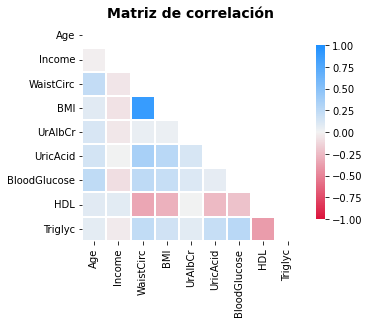

In [ ]:
# Se grafica la matriz de correlación con un mapa de calor

sns.heatmap(pearson_cormatrix_arr,
            mask = np.triu(np.ones_like(pearson_cormatrix_arr, dtype = bool)),
            cmap = sns.blend_palette(["crimson", ".95", "dodgerblue"], as_cmap = True),
            vmin = -1,
            vmax = 1,
            annot = False,
            center = 0, 
            square = True,             
            linewidths = 2,
            cbar_kws ={"shrink": 0.8})

plt.title("Matriz de correlación", fontsize = 14, fontweight = "bold")

plt.show()

###### Con base en este gráfico se observa que hay pocas correlaciones fuertes entre los features, siendo la más destacada la correlación entre BMI y WaistCirc (.88), lo cual es de esperar debido a la naturaleza de las variables. 

###### Por otro lado, se observan algunas correlaciones de leves a moderadas: 

- Waist Circunference vs HDL: -0.34
- Waist Circunference vs UricAcid: .35
- BMI vs HDL: -0.29
- HDL vs Triglyc: .39

##### Como estas correlaciones no son perfectas o cercanas a 1 se decide conservar las variables.

###### Estas correlaciones se visualizan en los gráficos de dispersión a continuación.

### Gráficos de dispersión

In [ ]:
# Se convierten las columnas que se utilizarán en los gráficos de dispersión a rdd

rdd_scatter = rdd_col(df, ["WaistCirc", "BMI", "UrAlbCr", "UricAcid", "HDL", "Triglyc"])

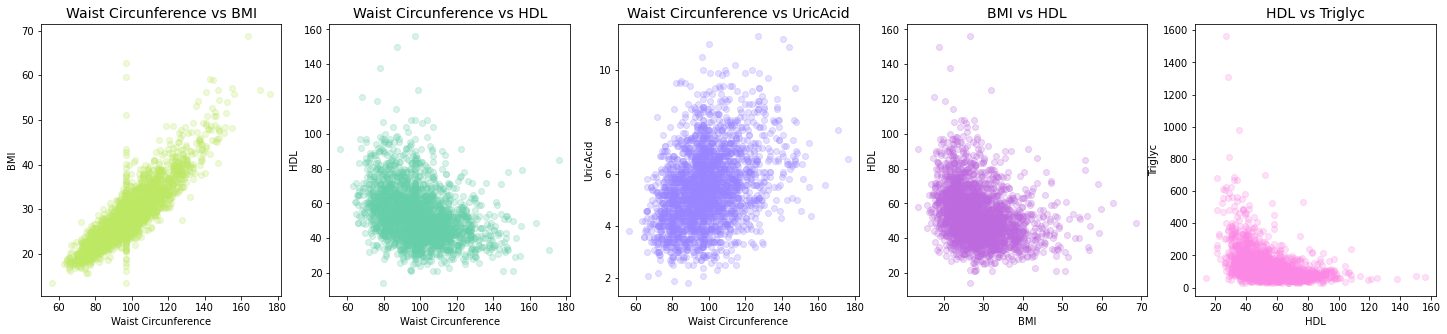

In [ ]:
# Matriz de gráficos de dispersión

fig, axs = plt.subplots(1, 5, figsize = (25, 5))

axs[0].scatter(rdd_scatter[0], rdd_scatter[1], color = "#bde863", alpha = 0.25)
axs[1].scatter(rdd_scatter[0], rdd_scatter[4], color = "#66cfaa", alpha = 0.25)
axs[2].scatter(rdd_scatter[0], rdd_scatter[3], color = "#9985ff", alpha = 0.25)
axs[3].scatter(rdd_scatter[1], rdd_scatter[4], color = "#be6adf", alpha = 0.25)
axs[4].scatter(rdd_scatter[4], rdd_scatter[5], color = "#fc88e6", alpha = 0.25)


axs[0].set_title("Waist Circunference vs BMI", fontsize = 14)
axs[0].set_xlabel("Waist Circunference")
axs[0].set_ylabel("BMI")

axs[1].set_title("Waist Circunference vs HDL", fontsize = 14)
axs[1].set_xlabel("Waist Circunference")
axs[1].set_ylabel("HDL")

axs[2].set_title("Waist Circunference vs UricAcid", fontsize = 14)
axs[2].set_xlabel("Waist Circunference")
axs[2].set_ylabel("UricAcid")

axs[3].set_title("BMI vs HDL", fontsize = 14)
axs[3].set_xlabel("BMI")
axs[3].set_ylabel("HDL")

axs[4].set_title("HDL vs Triglyc", fontsize = 14)
axs[4].set_xlabel("HDL")
axs[4].set_ylabel("Triglyc")

plt.show()

---

## One-Hot Encoding

In [ ]:
# Se convirtieron las columnas categóricas en variables dummy (1/0) para incluirlas en los modelos
# y se eliminaron las columnas orignales


df = df.withColumn("Sex_Female", when(col("Sex") == "Female", 1).otherwise(0))\
.withColumn("Sex_Male", when(col("Sex") == "Male", 1).otherwise(0))\
.withColumn("Marital_Single", when(col("Marital") == "Single", 1).otherwise(0))\
.withColumn("Marital_Married", when(col("Marital") == "Married", 1).otherwise(0))\
.withColumn("Marital_Separated", when(col("Marital") == "Separated", 1).otherwise(0))\
.withColumn("Marital_Divorced", when(col("Marital") == "Divorced", 1).otherwise(0))\
.withColumn("Marital_Widowed", when(col("Marital") == "Widowed", 1).otherwise(0))\
.withColumn("Marital_Unknown", when(col("Marital") == "Unknown", 1).otherwise(0))\
.withColumn("Race_Asian", when(col("Race") == "Asian", 1).otherwise(0))\
.withColumn("Race_Black", when(col("Race") == "Black", 1).otherwise(0))\
.withColumn("Race_Hispanic", when(col("Race") == "Hispanic", 1).otherwise(0))\
.withColumn("Race_MexAmerican", when(col("Race") == "MexAmerican", 1).otherwise(0))\
.withColumn("Race_Other", when(col("Race") == "Other", 1).otherwise(0))\
.withColumn("Race_White", when(col("Race") == "White", 1).otherwise(0))\
.withColumn("Albuminuria_normal_mild", when(col("Albuminuria") == 0, 1).otherwise(0))\
.withColumn("Albuminuria_moderate", when(col("Albuminuria") == 1, 1).otherwise(0))\
.withColumn("Albuminuria_severe", when(col("Albuminuria") == 2, 1).otherwise(0))\
.drop("Sex", "Marital", "Race", "Albuminuria")

In [ ]:
print("Columnas del conjunto de datos luego del One-Hot Encoding: \n")
print(df.columns)

Columnas del conjunto de datos luego del One-Hot Encoding: 

['ID', 'Age', 'Income', 'WaistCirc', 'BMI', 'UrAlbCr', 'UricAcid', 'BloodGlucose', 'HDL', 'Triglyc', 'MetSyndr', 'Sex_Female', 'Sex_Male', 'Marital_Single', 'Marital_Married', 'Marital_Separated', 'Marital_Divorced', 'Marital_Widowed', 'Marital_Unknown', 'Race_Asian', 'Race_Black', 'Race_Hispanic', 'Race_MexAmerican', 'Race_Other', 'Race_White', 'Albuminuria_normal_mild', 'Albuminuria_moderate', 'Albuminuria_severe']


---

## Estandarización

Se estandarizaron las columnas para evitar sesgos en el modelo debido las distintas escalas de las variables. 

In [ ]:
cols_stand = ['Age', 'Income', 'WaistCirc', 'BMI', 'UrAlbCr', 'UricAcid', 'BloodGlucose', 'HDL', 'Triglyc',
  'Sex_Female', 'Sex_Male', 'Marital_Single', 'Marital_Married', 'Marital_Separated',
'Marital_Divorced', 'Marital_Widowed', 'Marital_Unknown', 'Race_Asian', 'Race_Black', 'Race_Hispanic',
'Race_MexAmerican', 'Race_Other', 'Race_White', 'Albuminuria_normal_mild', 'Albuminuria_moderate', 'Albuminuria_severe']

In [ ]:
# Se convierten las columnas a vector, excepto por el ID y el target

assembler = VectorAssembler(inputCols= cols_stand, outputCol='Features')
vector_df = assembler.transform(df)
vector_df = vector_df.select('ID', 'Features', 'MetSyndr')

# Se estandarizan los features

standard_scaler = StandardScaler(inputCol='Features', outputCol='scaled')
scale_model = standard_scaler.fit(vector_df)

scaled_vector = scale_model.transform(vector_df).select('ID', 'MetSyndr', 'scaled')
print("Vector con los features estandarizados \n")
scaled_vector.show(10)

Vector con los features estandarizados 

+-----+--------+--------------------+
|   ID|MetSyndr|              scaled|
+-----+--------+--------------------+
|62161|       0|(26,[0,1,2,3,4,5,...|
|62164|       0|(26,[0,1,2,3,4,5,...|
|62169|       0|(26,[0,1,2,3,4,5,...|
|62172|       0|(26,[0,1,2,3,4,5,...|
|62177|       0|(26,[0,1,2,3,4,5,...|
|62178|       0|(26,[0,1,2,3,4,5,...|
|62184|       0|(26,[0,1,2,3,4,5,...|
|62189|       0|(26,[0,1,2,3,4,5,...|
|62191|       0|(26,[0,1,2,3,4,5,...|
|62195|       0|(26,[0,1,2,3,4,5,...|
+-----+--------+--------------------+
only showing top 10 rows



In [ ]:
# Se convierte el conjunto de datos ya escalado a dataframe para crear la tabla "tarea3" en postgres

scaled_df = (scaled_vector.withColumn("xs", vector_to_array(col("scaled"))).\
                                   select(['MetSyndr', 'ID'] + [col("xs")[i] for i in range(26)]))
tarea3 = scaled_df.toDF(*['MetSyndr', 'ID'] + cols_stand)
tarea3.show(2, vertical = True)

-RECORD 0---------------------------------------
 MetSyndr                | 0                    
 ID                      | 62161                
 Age                     | 1.2476711074533844   
 Income                  | 2.8282633531314367   
 WaistCirc               | 5.073896791530903    
 BMI                     | 3.5159891645789108   
 UrAlbCr                 | 0.015022873674016462 
 UricAcid                | 3.404296126705959    
 BloodGlucose            | 2.642109834123786    
 HDL                     | 2.6999373627344565   
 Triglyc                 | 0.8812192287560721   
 Sex_Female              | 0.0                  
 Sex_Male                | 1.9996599506903927   
 Marital_Single          | 2.4658555690711874   
 Marital_Married         | 0.0                  
 Marital_Separated       | 0.0                  
 Marital_Divorced        | 0.0                  
 Marital_Widowed         | 0.0                  
 Marital_Unknown         | 0.0                  
 Race_Asian         

---

## Almacenar datos

In [ ]:
# Se almacenó el conjunto de datos limpio en la base de datos

tarea3 \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "Metabolic") \
    .save()

---

## Descarga del conjunto de datos

In [ ]:
# Cargar el conjunto de datos. Esta vez desde la base de datos

# Reading single DataFrame in Spark by retrieving all rows from a DB table.
df_db = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "Metabolic") \
    .load()

df_db.show(2, vertical = True)

-RECORD 0---------------------------------------
 MetSyndr                | 0                    
 ID                      | 62161                
 Age                     | 1.2476711074533844   
 Income                  | 2.8282633531314367   
 WaistCirc               | 5.073896791530903    
 BMI                     | 3.5159891645789108   
 UrAlbCr                 | 0.015022873674016462 
 UricAcid                | 3.404296126705959    
 BloodGlucose            | 2.642109834123786    
 HDL                     | 2.6999373627344565   
 Triglyc                 | 0.8812192287560721   
 Sex_Female              | 0.0                  
 Sex_Male                | 1.9996599506903927   
 Marital_Single          | 2.4658555690711874   
 Marital_Married         | 0.0                  
 Marital_Separated       | 0.0                  
 Marital_Divorced        | 0.0                  
 Marital_Widowed         | 0.0                  
 Marital_Unknown         | 0.0                  
 Race_Asian         

---

# Entrenamiento de modelos de machine learning

### Preparación de los datos para los modelos

In [ ]:
# Se convirtieron los features de la tabla que fue almacenada en postgres a vector para ser recibidos por los modelos

assembler = VectorAssembler(inputCols= cols_stand, outputCol='Features')
vectorized_df_db = assembler.transform(df_db)
vectorized_df_db = vectorized_df_db.select('ID', 'Features', 'MetSyndr')
vectorized_df_db.show(5)

+-----+--------------------+--------+
|   ID|            Features|MetSyndr|
+-----+--------------------+--------+
|62161|(26,[0,1,2,3,4,5,...|       0|
|62164|(26,[0,1,2,3,4,5,...|       0|
|62169|(26,[0,1,2,3,4,5,...|       0|
|62172|(26,[0,1,2,3,4,5,...|       0|
|62177|(26,[0,1,2,3,4,5,...|       0|
+-----+--------------------+--------+
only showing top 5 rows



In [ ]:
# Se dividió el conjunto de datos en 70% train y 30% test

train, test = vectorized_df_db.randomSplit([0.7, 0.3])
print("Cantidad de observaciones en el set de entrenamiento: " + str(train.count()))
print("Cantidad de observaciones en el set de prueba: " + str(test.count()))

Cantidad de observaciones en el set de entrenamiento: 1669
Cantidad de observaciones en el set de prueba: 732


---

## Modelo 1: Regresión Logística

In [ ]:
# Se crea el modelo de regresión logística indicando como labels los valores de la variable target

lr = LogisticRegression(labelCol="MetSyndr", featuresCol="Features", maxIter=100)

In [ ]:
# Se especifican los parámetros a probar para la regresión logística

lrparamGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 0.5, 1.0, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0])
             .build())

In [ ]:
# Combinaciones posibles de los parámetros

parametros_LR = ["reg 0.01 & elastic 0.0","reg 0.01 & elastic 0.25","reg 0.01 & elastic 0.5","reg 0.01 & elastic 0.75","reg 0.01 & elastic 1.0",
                 "reg 0.1 & elastic 0.0","reg 0.1 & elastic 0.25","reg 0.1 & elastic 0.5", "reg 0.1 & elastic 0.75","reg 0.1 & elastic 1.0",
                 "reg 0.5 & elastic 0.0","reg 0.5 & elastic 0.25","reg 0.5 & elastic 0.5", "reg 0.5 & elastic 0.75","reg 0.5 & elastic 1.0",
                 "reg 1.0 & elastic 0.0","reg 1.0 & elastic 0.25","reg 1.0 & elastic 0.5", "reg 1.0 & elastic 0.75","reg 1.0 & elastic 1.0",
                 "reg 2.0 & elastic 0.0","reg 2.0 & elastic 0.25","reg 2.0 & elastic 0.5", "reg 2.0 & elastic 0.75","reg 2.0 & elastic 1.0"]

# Lista de modelos

nombres = ["Modelo 1", "Modelo 2", "Modelo 3", "Modelo 4", "Modelo 5", "Modelo 6", "Modelo 7", "Modelo 8", "Modelo 9", 
              "Modelo 10", "Modelo 11", "Modelo 12", "Modelo 13", "Modelo 14", "Modelo 15", "Modelo 16", "Modelo 17", "Modelo 18", 
              "Modelo 19", "Modelo 20", "Modelo 21", "Modelo 22", "Modelo 23", "Modelo 24", "Modelo 25"]

# Se crea un dataframe con los modelos y parámetros

parametros_LR_df = pd.DataFrame({"Modelo": nombres, "Parámetros": parametros_LR}).reset_index(drop = False)

In [ ]:
# Se indice el AUC (area under the curve) como la métrica a evaluar con base en la variable target

lrevaluator = BinaryClassificationEvaluator(labelCol = "MetSyndr", metricName = "areaUnderROC")

In [ ]:
# Se realiza la validación cruzada con 10 folds

lrcv = CrossValidator(estimator = lr,
                    estimatorParamMaps = lrparamGrid,
                    evaluator = lrevaluator,
                    numFolds = 10)

In [ ]:
# Se corren las validaciones cruzadas en el set de train
lrcvModel = lrcv.fit(train)

In [ ]:
# Se convierten las métricas en un dataframe para unirlo con el dataframe de modelso y sus parámetros

LR_parameter_score = pd.DataFrame(np.round(lrcvModel.avgMetrics, 4), columns = ["AUC_mean"]).reset_index(drop = False)

In [ ]:
# Se hace un join entre los dataframes de métricas y parámetros para encontrar cuál modelo tiene el mayor promedio de AUC

parameters_auc_df = parametros_LR_df.set_index("index").join(LR_parameter_score.set_index("index"), 
                                                    on = "index", how = "inner").sort_values("AUC_mean", ascending = False)
parameters_auc_df

Modelo               Parámetros  AUC_mean
index                                              
4       Modelo 5   reg 0.01 & elastic 1.0    0.9051
3       Modelo 4  reg 0.01 & elastic 0.75    0.9046
2       Modelo 3   reg 0.01 & elastic 0.5    0.9044
1       Modelo 2  reg 0.01 & elastic 0.25    0.9034
0       Modelo 1   reg 0.01 & elastic 0.0    0.9024
5       Modelo 6    reg 0.1 & elastic 0.0    0.8985
6       Modelo 7   reg 0.1 & elastic 0.25    0.8982
7       Modelo 8    reg 0.1 & elastic 0.5    0.8959
10     Modelo 11    reg 0.5 & elastic 0.0    0.8909
8       Modelo 9   reg 0.1 & elastic 0.75    0.8891
15     Modelo 16    reg 1.0 & elastic 0.0    0.8882
20     Modelo 21    reg 2.0 & elastic 0.0    0.8852
9      Modelo 10    reg 0.1 & elastic 1.0    0.8792
11     Modelo 12   reg 0.5 & elastic 0.25    0.8783
23     Modelo 24   reg 2.0 & elastic 0.75    0.5000
22     Modelo 23    reg 2.0 & elastic 0.5    0.5000
19     Modelo 20    reg 1.0 & elastic 1.0    0.5000
21     Modelo 22   reg 2.0 & elastic 0.25    0.5000
12     Modelo 13    reg 0.5 & elastic 0.5    0.5000
18     Modelo 19   reg 1.0 & elastic 0.75    0.5000
17     Modelo 18    reg 1.0 & elastic 0.5    0.5000
16     Modelo 17   reg 1.0 & elastic 0.25    0.5000
14     Modelo 15    reg 0.5 & elastic 1.0    0.5000
13     Modelo 14   reg 0.5 & elastic 0.75    0.5000
24     Modelo 25    reg 2.0 & elastic 1.0    0.5000

In [ ]:
# Se escoge el modelo con la mayor puntuación y se emplean sus parámetros para volver a entrenar el modelo

LR = LogisticRegression(labelCol="MetSyndr", featuresCol="Features", regParam = 0.01, elasticNetParam = 1.0)
LRModel = LR.fit(train)

In [ ]:
# Se prueba el modelo con la partición de test de los datos

lrpredictions = LRModel.transform(test)

In [ ]:
# Se evalúa la precisión de predicción del modelo elegido

evaluation_LR = lrevaluator.evaluate(lrpredictions)
print("Precisión: ", np.round(evaluation_LR, 4))

Precisión:  0.9137


In [ ]:
# Se muestra el label y la predicción que realizó el modelo

lrpredictions.select("ID", "Features", "MetSyndr", "prediction").show(10)

+-----+--------------------+--------+----------+
|   ID|            Features|MetSyndr|prediction|
+-----+--------------------+--------+----------+
|62177|(26,[0,1,2,3,4,5,...|       0|       0.0|
|62184|(26,[0,1,2,3,4,5,...|       0|       0.0|
|62191|(26,[0,1,2,3,4,5,...|       0|       0.0|
|62199|(26,[0,1,2,3,4,5,...|       1|       0.0|
|62202|(26,[0,1,2,3,4,5,...|       0|       0.0|
|62205|(26,[0,1,2,3,4,5,...|       1|       0.0|
|62215|(26,[0,1,2,3,4,5,...|       1|       0.0|
|62226|(26,[0,1,2,3,4,5,...|       0|       0.0|
|62248|(26,[0,1,2,3,4,5,...|       1|       1.0|
|62265|(26,[0,1,2,3,4,5,...|       1|       1.0|
+-----+--------------------+--------+----------+
only showing top 10 rows



---

## Bosque Aleatorio

In [ ]:
# Se crea un modelo de bosque aleatorio
rf = RandomForestClassifier(labelCol="MetSyndr", featuresCol="Features")

In [ ]:
# Se especifica el AUC como métrica de evaluación respecto al label

rfevaluator = BinaryClassificationEvaluator(labelCol = "MetSyndr", metricName = "areaUnderROC")

In [ ]:
# Se especifican los parámetros a probar

rfparamGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 5, 7, 10, 12])             
             .addGrid(rf.numTrees, [5, 10, 15, 20, 50])
             .build())

In [ ]:
# Se crea una validación cruzada de 10 folds
rfcv = CrossValidator(estimator = rf,
                      estimatorParamMaps = rfparamGrid,
                      evaluator = rfevaluator,
                      numFolds = 10)

In [ ]:
# Se corren las validaciones cruzadas

rfcvModel = rfcv.fit(train)

In [ ]:
# Combinaciones de parámetros de los modelos

parametros_RF = ["depth 2 & trees 5","depth 2 & trees 10", "depth 2 & trees 15", "depth 2 & trees 20", "depth 2 & trees 50",
                          "depth 5 & trees 5", "depth 5 & trees 10", "depth 5 & trees 15","depth 5 & trees 20", "depth 5 & trees 50",
                          "depth 7 & trees 5", "depth 7 & trees 10", "depth 7 & trees 15","depth 7 & trees 20","depth 7 & trees 50",  
                         "depth 10 & trees 5", "depth 10 & trees 10", "depth 10 & trees 15", "depth 10 & trees 20", "depth 10 & trees 50",
                         "depth 12 & trees 5", "depth 12 & trees 10", "depth 12 & trees 15","depth 12 & trees 20","depth 12 & trees 50"]

In [ ]:
# Se realiza un join de los parámetros de los modelos con el promedio del AUC

parametros_RF_df = pd.DataFrame({"Modelo": nombres, "Parámetros": parametros_RF}).reset_index(drop = False)
RF_auc = pd.DataFrame(np.round(rfcvModel.avgMetrics, 4), columns = ["AUC_mean"]).reset_index(drop = False)
parameters_auc_RF_df = parametros_RF_df.set_index("index").join(RF_auc.set_index("index"), on = "index", how = "inner").sort_values("AUC_mean", ascending = False)
parameters_auc_RF_df

Modelo           Parámetros  AUC_mean
index                                          
24     Modelo 25  depth 12 & trees 50    0.9522
19     Modelo 20  depth 10 & trees 50    0.9518
14     Modelo 15   depth 7 & trees 50    0.9509
18     Modelo 19  depth 10 & trees 20    0.9503
23     Modelo 24  depth 12 & trees 20    0.9501
13     Modelo 14   depth 7 & trees 20    0.9487
9      Modelo 10   depth 5 & trees 50    0.9451
12     Modelo 13   depth 7 & trees 15    0.9439
17     Modelo 18  depth 10 & trees 15    0.9425
7       Modelo 8   depth 5 & trees 15    0.9420
8       Modelo 9   depth 5 & trees 20    0.9414
11     Modelo 12   depth 7 & trees 10    0.9411
22     Modelo 23  depth 12 & trees 15    0.9401
16     Modelo 17  depth 10 & trees 10    0.9397
21     Modelo 22  depth 12 & trees 10    0.9389
6       Modelo 7   depth 5 & trees 10    0.9351
15     Modelo 16   depth 10 & trees 5    0.9288
5       Modelo 6    depth 5 & trees 5    0.9287
4       Modelo 5   depth 2 & trees 50    0.9284
10     Modelo 11    depth 7 & trees 5    0.9260
20     Modelo 21   depth 12 & trees 5    0.9254
3       Modelo 4   depth 2 & trees 20    0.9173
2       Modelo 3   depth 2 & trees 15    0.9116
1       Modelo 2   depth 2 & trees 10    0.8963
0       Modelo 1    depth 2 & trees 5    0.8619

In [ ]:
# Se elige el modelo ganador y se utilizan sus parámetros para entrenar el modelo que será probado después

rf = RandomForestClassifier(labelCol="MetSyndr", featuresCol="Features", maxDepth = 7, numTrees = 50)
rfModel = rf.fit(train)

In [ ]:
# Se emplea el modelo en el conjunto de test
rfpredictions = rfModel.transform(test)

# Tabla con la comparación entre el label y la predicción del bosque aleatorio

rfpredictions.show(10)

+-----+--------------------+--------+--------------------+--------------------+----------+
|   ID|            Features|MetSyndr|       rawPrediction|         probability|prediction|
+-----+--------------------+--------+--------------------+--------------------+----------+
|62177|(26,[0,1,2,3,4,5,...|       0|[48.0361539603876...|[0.96072307920775...|       0.0|
|62184|(26,[0,1,2,3,4,5,...|       0|[49.2386724643848...|[0.98477344928769...|       0.0|
|62191|(26,[0,1,2,3,4,5,...|       0|[40.4703665490918...|[0.80940733098183...|       0.0|
|62199|(26,[0,1,2,3,4,5,...|       1|[20.7067229817726...|[0.41413445963545...|       1.0|
|62202|(26,[0,1,2,3,4,5,...|       0|[41.7417412101519...|[0.83483482420303...|       0.0|
|62205|(26,[0,1,2,3,4,5,...|       1|[21.7289252253058...|[0.43457850450611...|       1.0|
|62215|(26,[0,1,2,3,4,5,...|       1|[35.9322782433966...|[0.71864556486793...|       0.0|
|62226|(26,[0,1,2,3,4,5,...|       0|[32.1444170784086...|[0.64288834156817...|       0.0|

In [ ]:
# Se evalúa la precisión del bosque aleatorio

evaluation_RF = lrevaluator.evaluate(rfpredictions)
print("Precisión: ", np.round(evaluation_RF, 4))

Precisión:  0.949


---

## Análisis de resultados de los modelos

Cabe aclarar primero que debido a que no se utiliza una semilla el modelo con el promedio de AUC más alto según los parámetros utilizados puede variar según la iteración, tanto para la regresión logística como para el bosque aleatorio. 

Luego de haber corrido ambos modelos se identifica que aunque los dos tienen una precisión buena, ya que aciertan el 90% del tiempo o más, es claro que el árbol de decisión tiene un mejor desempeño. 

Al evaluar los dos modelos utilizando la métrica del AUC, el bosque aleatorio obtiene aproximadamente un 95% de precisión, lo supera en un 5% la precisión de la regresión logística, que ronda el 90%. 

---

## Almacenamiento de tablas de Modelo1 y Modelo2

In [ ]:
# Se convierten las tablas con los datos del modelo a dataframe para poder guardarlas en postgres 

# Modelo 1: Regresión Logística

LR = (lrpredictions.withColumn("xs", vector_to_array(col("Features"))).\
                                   select(["MetSyndr", 'ID', 'prediction'] + [col("xs")[i] for i in range(26)]))
modelo1 = LR.toDF(*['MetSyndr', 'ID', 'prediction'] + cols_stand)
modelo1.show(2, vertical=True)

-RECORD 0---------------------------------------
 MetSyndr                | 0                    
 ID                      | 62177                
 prediction              | 0.0                  
 Age                     | 2.8923284763692094   
 Income                  | 0.8622754125400721   
 WaistCirc               | 5.08016076606178     
 BMI                     | 3.033106689414433    
 UrAlbCr                 | 0.031478340486230695 
 UricAcid                | 3.4737714902541086   
 BloodGlucose            | 2.7282655895843444   
 HDL                     | 2.8316416243312594   
 Triglyc                 | 1.321828843134108    
 Sex_Female              | 0.0                  
 Sex_Male                | 1.9996599506903927   
 Marital_Single          | 0.0                  
 Marital_Married         | 1.9996335867660766   
 Marital_Separated       | 0.0                  
 Marital_Divorced        | 0.0                  
 Marital_Widowed         | 0.0                  
 Marital_Unknown    

In [ ]:
# Modelo 2: Bosque aleatorio

RF = (lrpredictions.withColumn("xs", vector_to_array(col("Features"))).\
                                   select(["MetSyndr", 'ID', 'prediction'] + [col("xs")[i] for i in range(26)]))
modelo2 = RF.toDF(*['MetSyndr', 'ID', 'prediction'] + cols_stand)
modelo2.show(2, vertical=True)

-RECORD 0---------------------------------------
 MetSyndr                | 0                    
 ID                      | 62177                
 prediction              | 0.0                  
 Age                     | 2.8923284763692094   
 Income                  | 0.8622754125400721   
 WaistCirc               | 5.08016076606178     
 BMI                     | 3.033106689414433    
 UrAlbCr                 | 0.031478340486230695 
 UricAcid                | 3.4737714902541086   
 BloodGlucose            | 2.7282655895843444   
 HDL                     | 2.8316416243312594   
 Triglyc                 | 1.321828843134108    
 Sex_Female              | 0.0                  
 Sex_Male                | 1.9996599506903927   
 Marital_Single          | 0.0                  
 Marital_Married         | 1.9996335867660766   
 Marital_Separated       | 0.0                  
 Marital_Divorced        | 0.0                  
 Marital_Widowed         | 0.0                  
 Marital_Unknown    

In [ ]:
# Se almacena la tabla del modelo1 en postgres

modelo1 \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "modelo1") \
    .save()

In [ ]:
# Se almacena la tabla del modelo2 en postgres

modelo2 \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "modelo2") \
    .save()

---

### Referencias: 

NHS UK. (2019). *Metabolic syndrome.* https://www.nhs.uk/conditions/metabolic-syndrome/